In [1]:
from tqdm import tqdm
import time
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
import datetime as dt
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)
#display more columns
pd.set_option('display.max_columns',50)



# Loading Data

In [2]:
folder = "Data/Chicago/"
crime_files = sorted(glob.glob(folder+"*.csv"))
chicago_df = pd.concat([pd.read_csv(f) for f in crime_files])
chicago_df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,12258992,01/01/2021 01:00:00 PM,ASSAULT,SIMPLE,RESIDENCE,False,False,624,6.0,8.0,41.757849,-87.601708
1,12259387,01/01/2021 01:00:00 AM,ASSAULT,SIMPLE,GAS STATION,False,False,311,3.0,20.0,41.779998,-87.629295
2,12259526,01/01/2021 01:00:00 AM,ROBBERY,AGGRAVATED,SIDEWALK,False,False,1024,10.0,22.0,41.847145,-87.713645
3,12259461,01/01/2021 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,624,6.0,6.0,41.755932,-87.611409
4,12260596,01/01/2021 01:00:00 AM,BATTERY,AGGRAVATED - OTHER DANGEROUS WEAPON,APARTMENT,False,False,2533,25.0,37.0,41.903649,-87.745987
...,...,...,...,...,...,...,...,...,...,...,...,...
123545,13124429,06/30/2023 12:50:00 AM,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,1925,19.0,46.0,41.949093,-87.643737
123546,13124821,06/30/2023 12:50:00 PM,THEFT,RETAIL THEFT,TAVERN / LIQUOR STORE,False,False,1924,19.0,44.0,41.939906,-87.654410
123547,13124281,06/30/2023 12:52:00 AM,SEX OFFENSE,PUBLIC INDECENCY,STREET,False,False,2534,25.0,36.0,41.909763,-87.735792
123548,13124301,06/30/2023 12:57:00 AM,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,832,8.0,18.0,41.761952,-87.684388


# Chicago Dataframe

## test_date

In [3]:
test_date = chicago_df.loc[0, 'Date']
test_date



0    01/01/2021 01:00:00 PM
0    01/01/2022 01:00:00 AM
0    01/01/2023 01:00:00 PM
Name: Date, dtype: object

In [4]:
test_datetime = pd.to_datetime(test_date)
test_datetime

0   2021-01-01 13:00:00
0   2022-01-01 01:00:00
0   2023-01-01 13:00:00
Name: Date, dtype: datetime64[ns]

## Data

In [5]:
chicago_df['CrimeDateTime'] = pd.to_datetime(chicago_df['Date'], format="%m/%d/%Y %H:%M:%S %p")

In [6]:
chicago_df.isna().sum()

ID                          0
Date                        0
Primary Type                0
Description                 0
Location Description     2228
Arrest                      0
Domestic                    0
Beat                        0
District                    0
Ward                       23
Latitude                12119
Longitude               12119
CrimeDateTime               0
dtype: int64

In [7]:
# dropping na data
chicago_df = chicago_df.dropna(subset=['CrimeDateTime'])
chicago_df['CrimeDateTime'].isna().sum()

0

In [8]:
chicago_df = chicago_df.sort_values('CrimeDateTime')
chicago_df = chicago_df.set_index('CrimeDateTime')
chicago_df.info()
chicago_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 570913 entries, 2021-01-01 01:00:00 to 2023-06-30 12:58:00
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    570913 non-null  int64  
 1   Date                  570913 non-null  object 
 2   Primary Type          570913 non-null  object 
 3   Description           570913 non-null  object 
 4   Location Description  568685 non-null  object 
 5   Arrest                570913 non-null  bool   
 6   Domestic              570913 non-null  bool   
 7   Beat                  570913 non-null  int64  
 8   District              570913 non-null  float64
 9   Ward                  570890 non-null  float64
 10  Latitude              558794 non-null  float64
 11  Longitude             558794 non-null  float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 49.0+ MB


,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
CrimeDateTime,,,,,,,,,,,,
2021-01-01 01:00:00,12258992,01/01/2021 01:00:00 PM,ASSAULT,SIMPLE,RESIDENCE,False,False,624,6.0,8.0,41.757849,-87.601708
2021-01-01 01:00:00,12258637,01/01/2021 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE - PORCH / HALLWAY,False,False,323,3.0,6.0,41.761108,-87.621595
2021-01-01 01:00:00,12258531,01/01/2021 01:00:00 AM,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENCE - PORCH / HALLWAY,False,False,1032,10.0,22.0,41.837774,-87.712169
2021-01-01 01:00:00,12258976,01/01/2021 01:00:00 PM,BATTERY,AGGRAVATED OF AN UNBORN CHILD,STREET,False,True,1024,10.0,24.0,41.852538,-87.711171
2021-01-01 01:00:00,12260487,01/01/2021 01:00:00 PM,THEFT,OVER $500,STREET,False,False,2431,24.0,49.0,42.007171,-87.663703


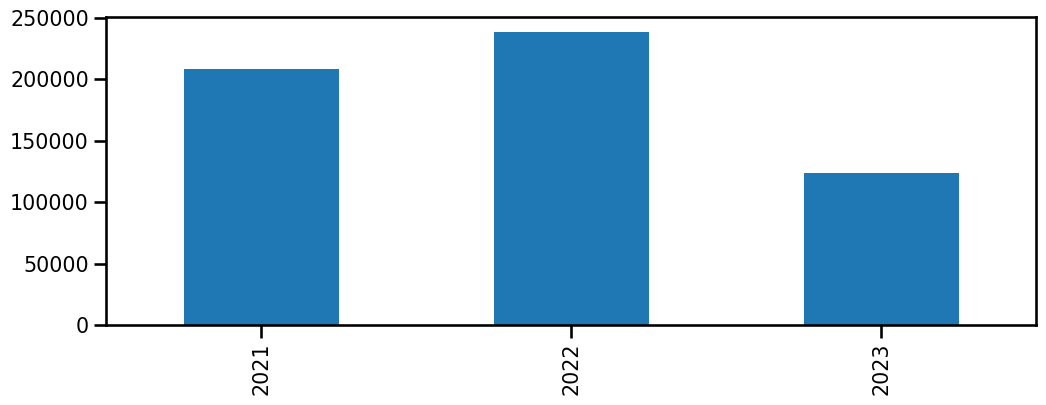

In [9]:
#viewing the crimes each year sum
years = chicago_df.index.year
years.value_counts().sort_index().plot(kind='bar');

- There is more crime in 2022 in chicago than any other year. Looks like crime was cut down by half in 2023.

In [10]:
## Inspecting the value_counts for the different types of crimes
crime_counts = chicago_df['Description'].value_counts()
crime_counts.sort_values()


POSSESS - LOOK-ALIKE DRUGS           1
AIDING ARRESTEE ESCAPE               1
MINOR MISREPRESENT AGE               1
USE OF METAL PIERCING BULLETS        1
FORNICATION                          1
                                 ...  
AUTOMOBILE                       37170
OVER $500                        42716
$500 AND UNDER                   43257
DOMESTIC BATTERY SIMPLE          47832
SIMPLE                           65939
Name: Description, Length: 302, dtype: int64

In [11]:
## Inspect the value_counts for the different types of crimes
crime_counts = chicago_df['Description'].value_counts().to_frame('Total # of Crimes')
crime_counts


,Total # of Crimes
SIMPLE,65939
DOMESTIC BATTERY SIMPLE,47832
$500 AND UNDER,43257
OVER $500,42716
AUTOMOBILE,37170
...,...
MANUFACTURE / DELIVER - HEROIN (BLACK TAR),1
DISCLOSE DOMESTIC VIOLENCE VICTIM LOCATION,1
GAME / AMUSEMENT DEVICE,1
SECOND DEGREE MURDER,1


In [12]:
# comparing
## demoing groupby with .size()
chicago_df.groupby("Description").size()



Description
$500 AND UNDER                                                  43257
ABUSE / NEGLECT - CARE FACILITY                                    33
AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SERIOUS INJURY       2082
AGG. PROTECTED EMPLOYEE - HANDS, FISTS, FEET, SERIOUS INJURY      100
AGGRAVATED                                                       1147
                                                                ...  
VIOLATION OF STALKING NO CONTACT ORDER                            238
VIOLATION OF SUMMARY CLOSURE                                        9
VIOLENT OFFENDER - ANNUAL REGISTRATION                             72
VIOLENT OFFENDER - DUTY TO REGISTER                                44
VIOLENT OFFENDER - FAIL TO REGISTER NEW ADDRESS                    14
Length: 302, dtype: int64

In [14]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 570913 entries, 2021-01-01 01:00:00 to 2023-06-30 12:58:00
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    570913 non-null  int64  
 1   Date                  570913 non-null  object 
 2   Primary Type          570913 non-null  object 
 3   Description           570913 non-null  object 
 4   Location Description  568685 non-null  object 
 5   Arrest                570913 non-null  bool   
 6   Domestic              570913 non-null  bool   
 7   Beat                  570913 non-null  int64  
 8   District              570913 non-null  float64
 9   Ward                  570890 non-null  float64
 10  Latitude              558794 non-null  float64
 11  Longitude             558794 non-null  float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 49.0+ MB


# Holiday Dataframe 

In [15]:
import holidays
from holidays import country_holidays

In [16]:
## making a date range that covers full dataset
all_days = pd.date_range(chicago_df["Date"].min(), chicago_df["Date"].max())
all_days



DatetimeIndex(['2021-01-01 01:00:00', '2021-01-02 01:00:00',
               '2021-01-03 01:00:00', '2021-01-04 01:00:00',
               '2021-01-05 01:00:00', '2021-01-06 01:00:00',
               '2021-01-07 01:00:00', '2021-01-08 01:00:00',
               '2021-01-09 01:00:00', '2021-01-10 01:00:00',
               ...
               '2022-12-22 01:00:00', '2022-12-23 01:00:00',
               '2022-12-24 01:00:00', '2022-12-25 01:00:00',
               '2022-12-26 01:00:00', '2022-12-27 01:00:00',
               '2022-12-28 01:00:00', '2022-12-29 01:00:00',
               '2022-12-30 01:00:00', '2022-12-31 01:00:00'],
              dtype='datetime64[ns]', length=730, freq='D')

In [17]:
## Create an instance of the US country holidays.
us_holidays = country_holidays('US')
us_holidays

holidays.country_holidays('US')

In [18]:
## Testing first date
print(all_days[0])
us_holidays.get(all_days[0])

2021-01-01 01:00:00


"New Year's Day"

In [19]:
## Getting us holidays for all dates
holiday_list = [us_holidays.get(day) for day in all_days]
holiday_list[:5]

["New Year's Day", None, None, None, None]

In [20]:
# For a specific subdivisions (e.g. state or province):
co_holidays = country_holidays('US', subdiv='CO')
co_holidays

holidays.country_holidays('US', subdiv='CO')

In [21]:
## Saving both holiday types as columns
chicago_df["US Holiday"] = [us_holidays.get(day) for day in chicago_df['Date']]
chicago_df['CO Holiday'] = [co_holidays.get(day) for day in chicago_df['Date']]
chicago_df.head()

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,US Holiday,CO Holiday
CrimeDateTime,,,,,,,,,,,,,,
2021-01-01 01:00:00,12258992,01/01/2021 01:00:00 PM,ASSAULT,SIMPLE,RESIDENCE,False,False,624,6.0,8.0,41.757849,-87.601708,New Year's Day,New Year's Day
2021-01-01 01:00:00,12258637,01/01/2021 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE - PORCH / HALLWAY,False,False,323,3.0,6.0,41.761108,-87.621595,New Year's Day,New Year's Day
2021-01-01 01:00:00,12258531,01/01/2021 01:00:00 AM,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENCE - PORCH / HALLWAY,False,False,1032,10.0,22.0,41.837774,-87.712169,New Year's Day,New Year's Day
2021-01-01 01:00:00,12258976,01/01/2021 01:00:00 PM,BATTERY,AGGRAVATED OF AN UNBORN CHILD,STREET,False,True,1024,10.0,24.0,41.852538,-87.711171,New Year's Day,New Year's Day
2021-01-01 01:00:00,12260487,01/01/2021 01:00:00 PM,THEFT,OVER $500,STREET,False,False,2431,24.0,49.0,42.007171,-87.663703,New Year's Day,New Year's Day


In [22]:
## US Holidays
chicago_df['US Holiday'].value_counts()

New Year's Day                                     2476
Juneteenth National Independence Day               2163
Memorial Day                                       1996
Martin Luther King Jr. Day                         1638
Washington's Birthday                              1508
Juneteenth National Independence Day (Observed)    1402
Independence Day                                   1401
Labor Day                                          1361
Veterans Day                                       1346
Columbus Day                                       1281
New Year's Day (Observed)                          1254
Thanksgiving                                        980
Christmas Day (Observed)                            949
Christmas Day                                       881
Independence Day (Observed)                         674
Name: US Holiday, dtype: int64

In [23]:
## MD Holidays
chicago_df['CO Holiday'].value_counts()

New Year's Day                                     2476
Juneteenth National Independence Day               2163
Memorial Day                                       1996
Martin Luther King Jr. Day                         1638
Washington's Birthday                              1508
Juneteenth National Independence Day (Observed)    1402
Independence Day                                   1401
Labor Day                                          1361
Veterans Day                                       1346
Columbus Day                                       1281
New Year's Day (Observed)                          1254
Thanksgiving                                        980
Christmas Day (Observed)                            949
Christmas Day                                       881
Independence Day (Observed)                         674
Name: CO Holiday, dtype: int64

# Resampled Dataframe

In [24]:
## Creating a Total # of Crimes
# getting list of  unique crime descriptions
crime_list = chicago_df['Description'].unique()
crime_list

array(['SIMPLE', 'RECKLESS FIREARM DISCHARGE',
       'AGGRAVATED OF AN UNBORN CHILD', 'OVER $500',
       'DOMESTIC BATTERY SIMPLE', 'TO RESIDENCE', 'AUTOMOBILE',
       'TO PROPERTY', 'COMPUTER FRAUD',
       'FINANCIAL IDENTITY THEFT $300 AND UNDER', 'AGGRAVATED',
       'RECKLESS CONDUCT', 'AGGRAVATED - OTHER DANGEROUS WEAPON',
       'PREDATORY', 'STRONG ARM - NO WEAPON',
       'UNLAWFUL POSSESSION - HANDGUN', '$500 AND UNDER',
       'FRAUD OR CONFIDENCE GAME', 'POSSESS - PCP',
       'AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SERIOUS INJURY',
       'OTHER VEHICLE OFFENSE',
       'AGGRAVATED DOMESTIC BATTERY - OTHER DANGEROUS WEAPON',
       'UNLAWFUL ENTRY', 'SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER',
       'FINANCIAL IDENTITY THEFT OVER $ 300', 'AGGRAVATED - HANDGUN',
       'PUBLIC INDECENCY', 'LICENSE VIOLATION', 'ARMED - HANDGUN',
       'TELEPHONE THREAT',
       'AGGRAVATED - HANDS, FISTS, FEET, NO / MINOR INJURY',
       'FROM BUILDING', 'NON-AGGRAVATED', 'FORCIBLE 

In [25]:
# Creating an empty dictionary  
CRIMES = {}
# 3. Loop through the list of crimes
for crime in crime_list:
    # I. Save a temp df of just the rows that match the crime
   temp = chicago_df.loc[chicago_df['Description']==crime].copy()
    # II. Resample the temp DataFrame as Daily data (crime counts) 
    # and keep ONLY the .size() 
   temp_res = temp.resample("D").size() 
   #III. Save the temporary DataFrame in the dictionary,
   #using the crime description as the key.
   CRIMES[crime] = temp_res.copy() 
CRIMES.keys()

dict_keys(['SIMPLE', 'RECKLESS FIREARM DISCHARGE', 'AGGRAVATED OF AN UNBORN CHILD', 'OVER $500', 'DOMESTIC BATTERY SIMPLE', 'TO RESIDENCE', 'AUTOMOBILE', 'TO PROPERTY', 'COMPUTER FRAUD', 'FINANCIAL IDENTITY THEFT $300 AND UNDER', 'AGGRAVATED', 'RECKLESS CONDUCT', 'AGGRAVATED - OTHER DANGEROUS WEAPON', 'PREDATORY', 'STRONG ARM - NO WEAPON', 'UNLAWFUL POSSESSION - HANDGUN', '$500 AND UNDER', 'FRAUD OR CONFIDENCE GAME', 'POSSESS - PCP', 'AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SERIOUS INJURY', 'OTHER VEHICLE OFFENSE', 'AGGRAVATED DOMESTIC BATTERY - OTHER DANGEROUS WEAPON', 'UNLAWFUL ENTRY', 'SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER', 'FINANCIAL IDENTITY THEFT OVER $ 300', 'AGGRAVATED - HANDGUN', 'PUBLIC INDECENCY', 'LICENSE VIOLATION', 'ARMED - HANDGUN', 'TELEPHONE THREAT', 'AGGRAVATED - HANDS, FISTS, FEET, NO / MINOR INJURY', 'FROM BUILDING', 'NON-AGGRAVATED', 'FORCIBLE ENTRY', 'TO LAND', 'TO VEHICLE', 'AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MINOR INJURY', 'UNLAWFUL USE - HANDGUN

In [26]:
resampled_df = pd.DataFrame(CRIMES)
resampled_df

,SIMPLE,RECKLESS FIREARM DISCHARGE,AGGRAVATED OF AN UNBORN CHILD,OVER $500,DOMESTIC BATTERY SIMPLE,TO RESIDENCE,AUTOMOBILE,TO PROPERTY,COMPUTER FRAUD,FINANCIAL IDENTITY THEFT $300 AND UNDER,AGGRAVATED,RECKLESS CONDUCT,AGGRAVATED - OTHER DANGEROUS WEAPON,PREDATORY,STRONG ARM - NO WEAPON,UNLAWFUL POSSESSION - HANDGUN,$500 AND UNDER,FRAUD OR CONFIDENCE GAME,POSSESS - PCP,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SERIOUS INJURY",OTHER VEHICLE OFFENSE,AGGRAVATED DOMESTIC BATTERY - OTHER DANGEROUS WEAPON,UNLAWFUL ENTRY,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,FINANCIAL IDENTITY THEFT OVER $ 300,...,VIOLATION OF SMOKING BAN,COMPOUNDING A CRIME,SOLICIT OFF PUBLIC WAY,OTHER PROSTITUTION OFFENSE,ARSONIST - FAIL TO REGISTER NEW ADDRESS,SECOND DEGREE MURDER,GAME / AMUSEMENT DEVICE,UNLAWFUL SALE - DELIVERY OF FIREARM AT SCHOOL,CALL OPERATION,MANUFACTURE / DELIVER - HEROIN (BLACK TAR),CRIMINAL TRANSMISSION OF HIV,ATTEMPT POSSESSION NARCOTICS,ANIMAL FIGHTING,POSSESS - HYPODERMIC NEEDLE,"THEFT / RECOVERY - CYCLE, SCOOTER, BIKE NO VIN",POSSESS KEYS OR DEVICE TO COIN MACHINE,INVOLUNTARY MANSLAUGHTER,DELIVER CONTROLLED SUBSTANCES TO PERSON UNDER 18,BRIBERY,SEX OFFENDER - PROHIBITED ZONE,OFFICIAL MISCONDUCT,FORNICATION,USE OF METAL PIERCING BULLETS,MINOR MISREPRESENT AGE,POSSESS - LOOK-ALIKE DRUGS
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01,51,17,2.0,28,97,5,22,58,3,38,2,5,6,5,3,37,36,6,1.0,2,8,4,8,3,63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,35,5,0.0,25,51,3,20,26,3,34,1,0,5,0,4,26,31,6,1.0,4,4,3,2,0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,44,9,0.0,17,62,4,27,41,0,48,1,1,2,1,4,20,36,0,0.0,0,2,4,4,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04,45,4,0.0,30,42,1,22,26,2,70,1,1,8,1,1,23,38,7,0.0,1,4,3,4,0,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,43,5,0.0,24,54,0,26,31,0,61,1,1,3,0,6,17,50,7,0.0,0,2,3,5,0,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,80,4,1.0,81,53,2,52,47,0,0,2,2,5,1,6,26,62,6,0.0,2,2,4,8,0,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-27,77,4,NaN,73,54,2,53,40,0,0,2,2,11,0,7,15,51,2,0.0,6,3,1,9,0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-28,75,9,NaN,50,44,5,46,25,1,1,1,3,14,0,9,11,37,0,0.0,1,3,1,5,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
## saving to disk
resampled_df.to_csv("Data/Chicago_crime_counts.csv")

In [28]:
## check our df.index
resampled_df.index



DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-24',
               '2023-06-25', '2023-06-26', '2023-06-27', '2023-06-28',
               '2023-06-29', '2023-06-30'],
              dtype='datetime64[ns]', name='CrimeDateTime', length=911, freq='D')

In [29]:
resampled_df = resampled_df.resample('D').asfreq()
resampled_df.head(3)


,SIMPLE,RECKLESS FIREARM DISCHARGE,AGGRAVATED OF AN UNBORN CHILD,OVER $500,DOMESTIC BATTERY SIMPLE,TO RESIDENCE,AUTOMOBILE,TO PROPERTY,COMPUTER FRAUD,FINANCIAL IDENTITY THEFT $300 AND UNDER,AGGRAVATED,RECKLESS CONDUCT,AGGRAVATED - OTHER DANGEROUS WEAPON,PREDATORY,STRONG ARM - NO WEAPON,UNLAWFUL POSSESSION - HANDGUN,$500 AND UNDER,FRAUD OR CONFIDENCE GAME,POSSESS - PCP,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SERIOUS INJURY",OTHER VEHICLE OFFENSE,AGGRAVATED DOMESTIC BATTERY - OTHER DANGEROUS WEAPON,UNLAWFUL ENTRY,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,FINANCIAL IDENTITY THEFT OVER $ 300,...,VIOLATION OF SMOKING BAN,COMPOUNDING A CRIME,SOLICIT OFF PUBLIC WAY,OTHER PROSTITUTION OFFENSE,ARSONIST - FAIL TO REGISTER NEW ADDRESS,SECOND DEGREE MURDER,GAME / AMUSEMENT DEVICE,UNLAWFUL SALE - DELIVERY OF FIREARM AT SCHOOL,CALL OPERATION,MANUFACTURE / DELIVER - HEROIN (BLACK TAR),CRIMINAL TRANSMISSION OF HIV,ATTEMPT POSSESSION NARCOTICS,ANIMAL FIGHTING,POSSESS - HYPODERMIC NEEDLE,"THEFT / RECOVERY - CYCLE, SCOOTER, BIKE NO VIN",POSSESS KEYS OR DEVICE TO COIN MACHINE,INVOLUNTARY MANSLAUGHTER,DELIVER CONTROLLED SUBSTANCES TO PERSON UNDER 18,BRIBERY,SEX OFFENDER - PROHIBITED ZONE,OFFICIAL MISCONDUCT,FORNICATION,USE OF METAL PIERCING BULLETS,MINOR MISREPRESENT AGE,POSSESS - LOOK-ALIKE DRUGS
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01,51,17,2.0,28,97,5,22,58,3,38,2,5,6,5,3,37,36,6,1.0,2,8,4,8,3,63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,35,5,0.0,25,51,3,20,26,3,34,1,0,5,0,4,26,31,6,1.0,4,4,3,2,0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,44,9,0.0,17,62,4,27,41,0,48,1,1,2,1,4,20,36,0,0.0,0,2,4,4,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
ts0 = resampled_df.index[0]
ts0



Timestamp('2021-01-01 00:00:00', freq='D')

In [31]:
## fill null values with 0
crimes_ts = resampled_df.fillna(0)
crimes_ts



,SIMPLE,RECKLESS FIREARM DISCHARGE,AGGRAVATED OF AN UNBORN CHILD,OVER $500,DOMESTIC BATTERY SIMPLE,TO RESIDENCE,AUTOMOBILE,TO PROPERTY,COMPUTER FRAUD,FINANCIAL IDENTITY THEFT $300 AND UNDER,AGGRAVATED,RECKLESS CONDUCT,AGGRAVATED - OTHER DANGEROUS WEAPON,PREDATORY,STRONG ARM - NO WEAPON,UNLAWFUL POSSESSION - HANDGUN,$500 AND UNDER,FRAUD OR CONFIDENCE GAME,POSSESS - PCP,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SERIOUS INJURY",OTHER VEHICLE OFFENSE,AGGRAVATED DOMESTIC BATTERY - OTHER DANGEROUS WEAPON,UNLAWFUL ENTRY,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,FINANCIAL IDENTITY THEFT OVER $ 300,...,VIOLATION OF SMOKING BAN,COMPOUNDING A CRIME,SOLICIT OFF PUBLIC WAY,OTHER PROSTITUTION OFFENSE,ARSONIST - FAIL TO REGISTER NEW ADDRESS,SECOND DEGREE MURDER,GAME / AMUSEMENT DEVICE,UNLAWFUL SALE - DELIVERY OF FIREARM AT SCHOOL,CALL OPERATION,MANUFACTURE / DELIVER - HEROIN (BLACK TAR),CRIMINAL TRANSMISSION OF HIV,ATTEMPT POSSESSION NARCOTICS,ANIMAL FIGHTING,POSSESS - HYPODERMIC NEEDLE,"THEFT / RECOVERY - CYCLE, SCOOTER, BIKE NO VIN",POSSESS KEYS OR DEVICE TO COIN MACHINE,INVOLUNTARY MANSLAUGHTER,DELIVER CONTROLLED SUBSTANCES TO PERSON UNDER 18,BRIBERY,SEX OFFENDER - PROHIBITED ZONE,OFFICIAL MISCONDUCT,FORNICATION,USE OF METAL PIERCING BULLETS,MINOR MISREPRESENT AGE,POSSESS - LOOK-ALIKE DRUGS
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01,51,17,2.0,28,97,5,22,58,3,38,2,5,6,5,3,37,36,6,1.0,2,8,4,8,3,63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-02,35,5,0.0,25,51,3,20,26,3,34,1,0,5,0,4,26,31,6,1.0,4,4,3,2,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-03,44,9,0.0,17,62,4,27,41,0,48,1,1,2,1,4,20,36,0,0.0,0,2,4,4,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-04,45,4,0.0,30,42,1,22,26,2,70,1,1,8,1,1,23,38,7,0.0,1,4,3,4,0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-05,43,5,0.0,24,54,0,26,31,0,61,1,1,3,0,6,17,50,7,0.0,0,2,3,5,0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,80,4,1.0,81,53,2,52,47,0,0,2,2,5,1,6,26,62,6,0.0,2,2,4,8,0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-27,77,4,0.0,73,54,2,53,40,0,0,2,2,11,0,7,15,51,2,0.0,6,3,1,9,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-28,75,9,0.0,50,44,5,46,25,1,1,1,3,14,0,9,11,37,0,0.0,1,3,1,5,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Q1: Which district has the most crimes? Which has the least?


In [32]:
df_ts = chicago_df.groupby('District').sum()
df_ts

C:\Users\caill\AppData\Local\Temp\ipykernel_17452\655895210.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ts = chicago_df.groupby('District').sum()


,ID,Arrest,Domestic,Beat,Ward,Latitude,Longitude
District,,,,,,,
1.0,365977380324,4075,2188,3499242,672383.0,1.164907e+06,-2.437907e+06
2.0,353065159764,2332,5699,6187028,152914.0,1.142206e+06,-2.393420e+06
3.0,364787600174,2751,7633,9335720,294511.0,1.189509e+06,-2.494450e+06
4.0,423792808008,3021,8687,14121994,272036.0,1.380666e+06,-2.896867e+06
5.0,307423403757,3020,6597,12702879,422267.0,1.003031e+06,-2.108277e+06
6.0,453477869874,4336,9380,22363566,474378.0,1.480793e+06,-3.108438e+06
7.0,330735197073,3553,7502,18976347,350327.0,1.080878e+06,-2.267911e+06
8.0,450642057819,3361,7325,29285671,608244.0,1.461794e+06,-3.069146e+06
9.0,314993244418,2731,4827,22964645,349287.0,1.026448e+06,-2.151814e+06


# 